# COLOP in Spectral Blueing Mode

IPython notebook to calculate operator for spectral blueing using seismic amplitude spectrum and well AI spectrum exported from OpendTect.

First sample of the exported seismic amplitude spectrum was edited to be different than zero (0.01Hz), first row of well based AI was deleted as it was 0.00000Hz

Standalone windows binary and source codes are available at my [Home page](http://peter.zahuczki.hu)

In [8]:
import sys
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
%matplotlib inline

Define the input and output files and input parameters for operator estimation

In [9]:
#Input spectrum files
seisfile="F2_01_seismic_amplitude_spectrum.dat"
wellfile="F2_01_well_AI_amplitude_spectrum.dat"

#Shape parameter for Kaiser window
beta=70

#Normalized amplitude treshold, smaller amplitudes will be skipped during computation
treshold=0.2

#Operator phase spectrum depending on polarity of the seismic data
#SEG normal(AI increase = through): phase=0; SEG reverse (AI increase = Peak): phase=-180
phase=-90

#Number of samples of the operator
num=100

#Ouput operator file
operatorfile="F2_01_colour_operator.dat"

Load spectrums from input files, and calculate linear regression based on well impedance spectrum on log-log scale

Regression results:
Intercept: 8.59168017229729
Slope    : -0.77710664924029
R-value  : -0.7748600564457918


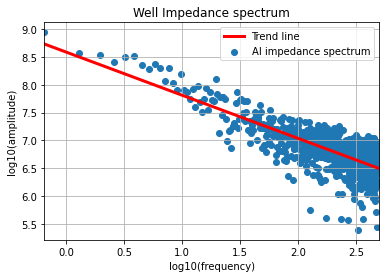

In [10]:
#Load exported spectrums from OpendTect
freqseis, ampseis=np.loadtxt(seisfile, unpack=True)
freqwell, ampwell=np.loadtxt(wellfile, unpack=True)

# dB to amplitude conversion
ampwell=np.power(10,ampwell/20)
ampseis=np.power(10,ampseis/20)

#Normalize seismic spectrum
normseis = ampseis / np.max(ampseis)

#Calculate logarithmic well spectrum
logfreq= np.log10(freqwell)
logamp=np.log10(ampwell)

#Linear regression on logarithmic well spectrum
slope, intercept, rvalue, pvalue, stderr = linregress(logfreq,logamp)
print ('Regression results:')
print ("Intercept:", intercept)
print ("Slope    :", slope)
print ("R-value  :", rvalue)

#Plot well based AI spectrum with regression line
lintrend=intercept+slope*logfreq
plt.figure(0)
plt.title('Well Impedance spectrum')
plt.scatter(logfreq,logamp, label="AI impedance spectrum")
plt.xlabel("log10(frequency)")
plt.ylabel("log10(amplitude)")
plt.plot(logfreq,lintrend, label="Trend line", linewidth=3, color='red')
plt.xlim(np.min(logfreq),np.max(logfreq))
plt.legend()
plt.grid()
plt.show()

Calculate raw operator, based on the ratio of trend spectrum from wells and normalized seismic amplitude spectrum


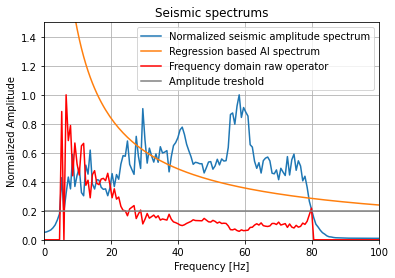

In [11]:
#Calculate regression based trend well spectrum
WelltrendSpectrum = intercept*np.power(freqseis,slope)

#Calculate residual spectrum
ResidualSpectrum=np.zeros(len(normseis))
for i in range(len(normseis)):
    if normseis[i]>treshold:
        ResidualSpectrum[i]= WelltrendSpectrum[i] / normseis[i]
        
#Normalize residual spectrum
ResidualSpectrum=ResidualSpectrum / np.max(ResidualSpectrum)

#Plot normalized seismic spectrum with well trend spectrum
plt.figure(1)
thold=np.ones(len(freqseis))
thold=treshold*thold
plt.title('Seismic spectrums')
plt.plot(freqseis,normseis, label='Normalized seismic amplitude spectrum')
plt.plot(freqseis,WelltrendSpectrum, label='Regression based AI spectrum')
plt.plot(freqseis,ResidualSpectrum, label='Frequency domain raw operator', color='red')
plt.plot(freqseis,thold, label='Amplitude treshold', color='grey')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Normalized Amplitude')
plt.ylim(0,1.5)
plt.xlim(0,100)
plt.legend()
plt.grid()
plt.show()

Precalculation for inverse dft, to transform raw operator to time domain.
First setup a complex amplitude spectrum with the given phase, then calculate ifft and reorder the result.

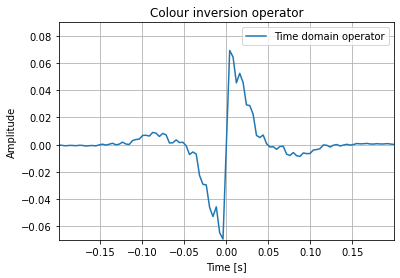

In [12]:
#Calculate dt
dt=1/(2*np.max(freqseis))

#Setup complex amplitude spectrum for ifft with phase assumption
cspectrum_poz=ResidualSpectrum*(np.cos(np.radians(phase))+1j*np.sin(np.radians(phase)))
cspectrum_neg=ResidualSpectrum*(np.cos(-1*np.radians(phase))+1j*np.sin(-1*np.radians(phase)))
rev_cspectrum_neg=np.fliplr([cspectrum_neg])[0]
input_cspectrum=np.append(cspectrum_poz,rev_cspectrum_neg)

#Calculate ifft and reorder arrays
t_op=np.fft.ifft(input_cspectrum)
start_t=(-1/2)*dt*(len(input_cspectrum))+dt
t_shift=np.linspace(start_t,-1*start_t,len(t_op))-dt/2
t_op_shift=np.fft.ifftshift(t_op)

#Tapering of the time domain operator using a Kaiser window, and calculation of the operator triming indexes, and plot the final operator

#Tapering
window_kaiser=np.kaiser(len(t_shift),beta)

t_op_final=t_op_shift*window_kaiser

#Operator trimming indexes
start_i=(int(len(t_shift)/2))-int(num/2)
stop_i=(int(len(t_shift)/2))+int(num/2)

#Plot final time domain operator
plt.figure(2)
plt.title('Colour inversion operator')
plt.plot(t_shift,t_op_final.real, label='Time domain operator')
#plt.fill_between(t_shift, t_op_final.real,0, t_op_final > 0.0, interpolate=False, hold=True, color='blue', alpha = 0.5)
plt.xlim(t_shift[start_i],t_shift[stop_i])
plt.ylim(-0.07,0.09)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

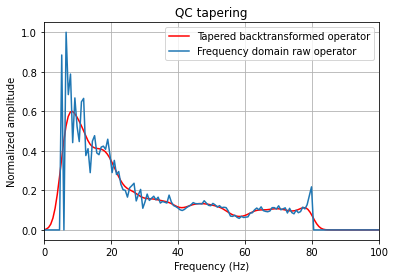

Operator is saved to: F2_01_colour_operator.dat


In [13]:
#Save final operator
np.savetxt(operatorfile,t_op_final[start_i:stop_i].real)

#QC operator by transform tapered operator to frequency domain
bt_op=np.fft.fft(t_op_final)
backfreq=np.fft.fftfreq(len(t_op_final),dt)

#Keeping only the positive frequencies
backfreq_poz=backfreq[:int(len(backfreq)/2)]
bt_op_poz=bt_op[:int(len(bt_op)/2)]

output_spectrum=bt_op_poz*normseis

plt.figure(3)
plt.title('QC tapering')
plt.plot(backfreq_poz,abs(bt_op_poz), label='Tapered backtransformed operator', color='red')
plt.plot(freqseis,ResidualSpectrum, label='Frequency domain raw operator')
#plt.fill_between(backfreq_poz, abs(bt_op_poz),0, abs(bt_op_poz) > 0.0, interpolate=False, hold=True, color='red', alpha = 0.3)
plt.ylabel('Normalized amplitude')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,100)
plt.legend()
plt.grid()
plt.show()
print('Operator is saved to:',operatorfile)